# Codon Frequencies
This notebook parses FASTQ files and calculates the frequency of codons at site 734 in Zika Virus NS5 protein.

FASTQ files for each cell population are specified in `samplesheet.csv`

## Notebook setup
Imports

In [1]:
import gzip
import os.path
import numpy as np
import pandas as pd
import plotnine as p9
import regex
from Bio import SeqIO

# print imports and versions
# copied from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
print('\n'.join(f'{m.__name__}=={m.__version__}' \
                for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.19.1
pandas==1.3.2
plotnine==0.8.0
regex==2.5.83


Input data

In [2]:
samplesheet = 'tmp.csv'
reference_file = 'ns5.fasta'
codons_file = 'codons.csv.gz'

Analysis parameters

In [3]:
codon_start = 2203  # nposition in reference for first codon nt
upstream_length = 15  # length of sequence before codon to search for
downstream_length = 15  # length of sequence after codon to search for
mismatches = 1  # number of mismatches allowed (per upstream/downstream sequence)
nucleotides_allowed = 'ACGT'

Notebook aesthetics

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_RICH = ['#648FFF', '#FFB000', '#DC267F', '#785EF0', '#FE6100']

## Load data
Load samples

In [5]:
samples = pd.read_csv(samplesheet)
display(samples)

,sample_name,infected,IFN,read,fastq_file
0,WT_NS5_Sample,True,None,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
1,WT_NS5_Sample,True,None,R2,/shared/ngs/illumina/bloom_lab/210917_M04866_0...


Load reference sequence

In [6]:
reference = SeqIO.read(reference_file, 'fasta')
print(reference.id)
print(reference.seq)

NS5
CGTGGAGGTGGGACGGGAGAGACTCTGGGAGAGAAGTGGAAAGCTCGTCTGAATCAGATGTCGGCCCTGGAGTTCTACTCTTATAAAAAGTCAGGTATCACTGAAGTGTGTAGAGAGGAGGCTCGCCGTGCCCTCAAGGATGGAGTGGCCACAGGAGGACATGCCGTATCCCGGGGAAGTGCAAAGCTCAGATGGTTGGTGGAGAGAGGATATCTGCAGCCCTATGGGAAGGTTGTTGACCTCGGATGTGGCAGAGGGGGCTGGAGCTATTATGCCGCCACCATCCGCAAAGTGCAGGAGGTGAGAGGATACACAAAGGGAGGTCCCGGTCATGAAGAACCCATGCTGGTGCAAAGCTATGGGTGGAACATAGTTCGTCTCAAGAGTGGAGTGGACGTCTTCCACATGGCGGCTGAGCCGTGTGACACTCTGCTGTGTGACATAGGTGAGTCATCATCTAGTCCTGAAGTGGAAGAGACACGAACACTCAGAGTGCTCTCTATGGTGGGGGACTGGCTTGAAAAAAGACCAGGGGCCTTCTGTATAAAGGTGCTGTGCCCATACACCAGCACTATGATGGAAACCATGGAGCGACTGCAACGTAGGCATGGGGGAGGATTAGTCAGAGTGCCATTGTCTCGCAACTCCACACATGAGATGTACTGGGTCTCTGGGGCAAAGAGCAACATCATAAAAAGTGTGTCCACCACAAGTCAGCTCCTCCTGGGACGCATGGATGGCCCCAGGAGGCCAGTGAAATATGAGGAGGATGTGAACCTCGGCTCGGGTACACGAGCTGTGGCAAGCTGTGCTGAGGCTCCTAACATGAAAATCATCGGCAGGCGCATTGAGAGAATCCGCAATGAACATGCAGAAACATGGTTTCTTGATGAAAACCACCCATACAGGACATGGGCCTACCATGGGAGCTACGAAGCCCCCACGCAAGGATCAGCGTCTTCCCTCGTGAACGGGGTTGTTAGACTCCTGTCAAAG

## Parse codon sequence
Parse sequences if codons file is not already given in root directory.

Open codons file if present

In [7]:
if os.path.isfile(codons_file):
    print(f'Loading results from {codons_file}')
    results = pd.read_csv(codons_file)
    print('Done.')
else:
    pass

Extract sequences upstream and downstream of codon

In [8]:
if os.path.isfile(codons_file):
    pass
else:
    # feature positions in reference sequence
    codon_end = codon_start + 2
    upstream_start = codon_start - upstream_length
    upstream_end = codon_start - 1
    downstream_start = codon_end + 1
    downstream_end = codon_end + downstream_length

    # feature values
    # python indexing is not inclusive of first coordinate, so
    # all start positions are adjusted by -1
    codon_reference = reference.seq[(codon_start-1):codon_end]
    upstream = reference.seq[(upstream_start-1):upstream_end]
    downstream = reference.seq[(downstream_start-1):downstream_end]

    # print
    print(f'The codon starts at position {codon_start} and '
          f'ends at position {codon_end} in the reference.')
    print(f'The codon sequence in the reference is: {codon_reference}\n')
    print(f'The upstream search sequence starts at position {upstream_start} '
          f'and ends at position {upstream_end} in the reference.')
    print(f'The upstream search sequence is: {upstream}\n')
    print(f'The downstream search sequence starts at position {downstream_start} '
          f'and ends at position {downstream_end} in the reference.')
    print(f'The downstream search sequence is: {downstream}')

The codon starts at position 2203 and ends at position 2205 in the reference.
The codon sequence in the reference is: GAT

The upstream search sequence starts at position 2188 and ends at position 2202 in the reference.
The upstream search sequence is: CCTTGCCGCCACCAA

The downstream search sequence starts at position 2206 and ends at position 2220 in the reference.
The downstream search sequence is: GAACTGATTGGCCGA


Build regex search

In [9]:
if os.path.isfile(codons_file):
    pass
else:
    pattern = (f'(?:{upstream}){{e<={mismatches}}}' +  # match upstream
                  f'([{nucleotides_allowed}]{{3}})' +  # match and capture codon
                  f'(?:{downstream}){{e<={mismatches}}}')  # match downstream
    print(f'The search pattern for will be:\n{pattern}')

The search pattern for will be:
(?:CCTTGCCGCCACCAA){e<=1}([ACGT]{3})(?:GAACTGATTGGCCGA){e<=1}


Iterate through reads and store codons:

In [10]:
if os.path.isfile(codons_file):
    pass
else:
    results = list()

    for index, sample in samples.iterrows():
        assert sample['read'] in ['R1', 'R2'], "unrecognized read"
        with gzip.open(sample['fastq_file'], mode='rt') as handle:
            print(f'Parsing data for {sample["sample_name"]} {sample["read"]}')
            print(f'File is:  {sample["fastq_file"]}')
            seqs = SeqIO.parse(handle, 'fastq')
            for sequence in seqs:
                if(sample['read'] == 'R1'):
                    search_seq = sequence.seq
                elif(sample['read'] == 'R2'):
                    search_seq = sequence.seq.reverse_complement()
                result = regex.search(pattern, str(search_seq))
                if result == None:
                    match = 'failed_parse'
                    codon = 'failed_parse'
                else:
                    match = result.group(0)
                    codon = result.group(1)
                results.append((sample['sample_name'],
                                sample['read'],
                                sequence.id,
                                match,
                                codon))
            print('\n')

    results = pd.DataFrame(results)
    results.columns = ['sample_name','read','read_id','match_string','codon']
    print(f'Saving results to {codons_file}')
    results.to_csv(codons_file)

Parsing data for WT_NS5_Sample R1
File is:  /shared/ngs/illumina/bloom_lab/210917_M04866_0509_000000000-JW58W/Data/Intensities/BaseCalls/WT-NS5-Sample_S1_L001_R1_001.fastq.gz


Parsing data for WT_NS5_Sample R2
File is:  /shared/ngs/illumina/bloom_lab/210917_M04866_0509_000000000-JW58W/Data/Intensities/BaseCalls/WT-NS5-Sample_S1_L001_R2_001.fastq.gz


Saving results to codons.csv.gz


In [20]:
display(results)

,sample_name,read,read_id,match_string,codon
0,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:17362:1802,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT
1,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:18222:1836,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT
2,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:17286:1855,CCCTTGCCGCCACCAACATGAACTGATTGGCCGA,CAT
3,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:16342:1902,CCCTTGCCGCCACCAATATGAACTGATTGGCCGA,TAT
4,WT_NS5_Sample,R1,M04866:509:000000000-JW58W:1:1101:16389:1914,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT
...,...,...,...,...,...
3676543,WT_NS5_Sample,R2,M04866:509:000000000-JW58W:1:2114:16337:29206,CCCTTGCCGCCACCAAGATGAACTGATTGGCCGA,GAT
3676544,WT_NS5_Sample,R2,M04866:509:000000000-JW58W:1:2114:16858:29210,CCCTTGCCGCCACCAAGATGAACTGATTGGCCGA,GAT
3676545,WT_NS5_Sample,R2,M04866:509:000000000-JW58W:1:2114:14480:29213,CCCTTGCCGCCACCAAGATGAACTGAGTGGCCGA,GAT
3676546,WT_NS5_Sample,R2,M04866:509:000000000-JW58W:1:2114:13993:29216,CCCTTGCCGCCACCAAAATGAACTGATTGGCCGA,AAT


## Plot quality control

Number of reads with codon successfully parsed per sample:

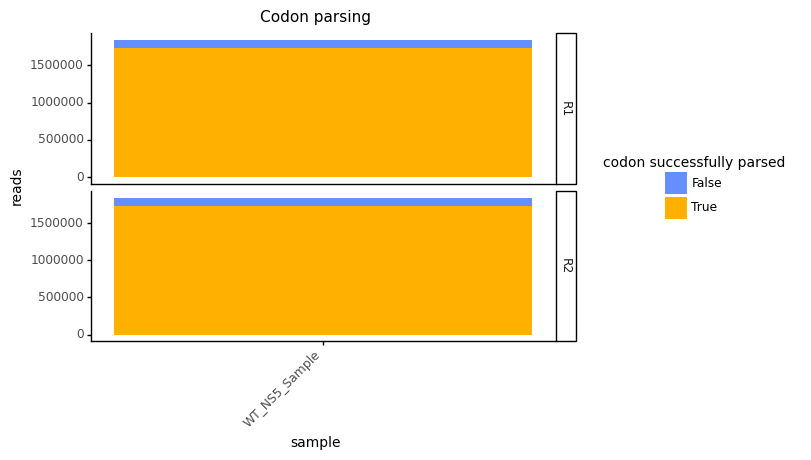

<ggplot: (8757510980587)>

In [76]:
parsing_qc = (p9.ggplot(results) +
              p9.aes(x='sample_name',
                     fill='codon != "failed_parse"') +
              p9.geom_bar(stat='count') +
              p9.facet_grid('read~') +
              p9.ggtitle('Codon parsing') +
              p9.labs(x='sample',
                      y='reads',
                      fill='codon successfully parsed') +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(parsing_qc)

Pair reads by read_id

In [75]:
results_pairs = (
    results
    .pivot(index=['sample_name','read_id'], columns='read', values='codon')
    .reset_index())

#  Check for missing mate
results_pairs['missing_mate'] = (
    results_pairs['R1'].isnull() | results_pairs['R2'].isnull()
)

#  Check for mismatch
results_pairs['pair_mismatch'] = (
    results_pairs['R1'] != results_pairs['R2']
)

display(results_pairs)

read,sample_name,read_id,R1,R2,missing_mate,pair_mismatch
0,WT_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:11899,GAT,GAT,False,False
1,WT_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:9731,GAT,GAT,False,False
2,WT_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10001:23608,failed_parse,failed_parse,False,False
3,WT_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10001:23633,GAT,GAT,False,False
4,WT_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10001:3645,GAT,GAT,False,False
...,...,...,...,...,...,...
1838269,WT_NS5_Sample,M04866:509:000000000-JW58W:1:2114:9998:27740,GAT,GAT,False,False
1838270,WT_NS5_Sample,M04866:509:000000000-JW58W:1:2114:9998:9015,GAT,GAT,False,False
1838271,WT_NS5_Sample,M04866:509:000000000-JW58W:1:2114:9999:21056,GAT,GAT,False,False
1838272,WT_NS5_Sample,M04866:509:000000000-JW58W:1:2114:9999:23438,GAT,GAT,False,False


Plot missing mates

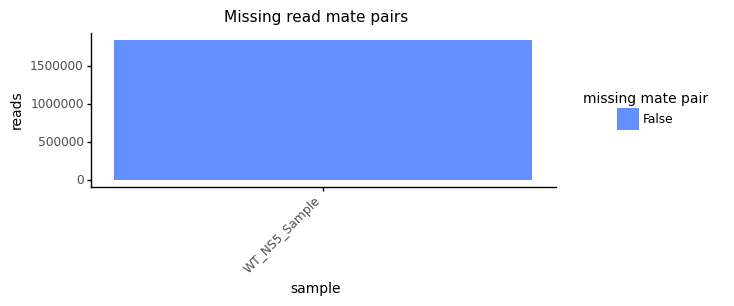

<ggplot: (8757505598449)>

In [79]:
mate_pair_qc = (p9.ggplot(results_pairs) +
              p9.aes(x='sample_name',
                     fill='missing_mate') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('Missing read mate pairs') +
              p9.labs(x='sample',
                      y='reads',
                      fill='missing mate pair') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(mate_pair_qc)

Plot mismatched codon values from paired reads

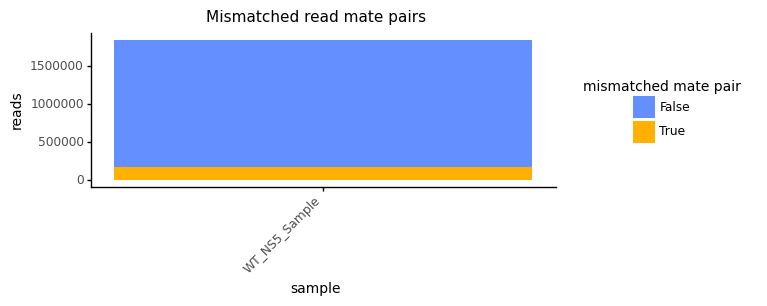

<ggplot: (8757506123722)>

In [80]:
mismatched_pairs_qc = (p9.ggplot(results_pairs) +
              p9.aes(x='sample_name',
                     fill='pair_mismatch') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('Mismatched read mate pairs') +
              p9.labs(x='sample',
                      y='reads',
                      fill='mismatched mate pair') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(mismatched_pairs_qc)

## Filter data
Filter the data based on the QC metrics above.

In [86]:
results_filtered = (
    results_pairs
    .query(
        'missing_mate == False & '
        'pair_mismatch == False & '
        'R1 != "failed_parse" & '
        'R2 != "failed_parse"')
    [['sample_name', 'read_id', 'R1']]
    .rename(columns={'R1': 'codon'})
)

display(results_filtered)

read,sample_name,read_id,codon
0,WT_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:11899,GAT
1,WT_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10000:9731,GAT
3,WT_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10001:23633,GAT
4,WT_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10001:3645,GAT
5,WT_NS5_Sample,M04866:509:000000000-JW58W:1:1101:10002:19760,GAT
...,...,...,...
1838268,WT_NS5_Sample,M04866:509:000000000-JW58W:1:2114:9998:23016,GAT
1838269,WT_NS5_Sample,M04866:509:000000000-JW58W:1:2114:9998:27740,GAT
1838270,WT_NS5_Sample,M04866:509:000000000-JW58W:1:2114:9998:9015,GAT
1838271,WT_NS5_Sample,M04866:509:000000000-JW58W:1:2114:9999:21056,GAT


## Plot codon frequencies

Bring in experiment info

In [93]:
results_annotated = pd.merge(
    left=samples[['sample_name', 'infected', 'IFN']].drop_duplicates(),
    right=results_filtered,
    on='sample_name',
    how='right',
    validate='one_to_many'
)

display(results_annotated)

,sample_name,infected,IFN,read_id,codon
0,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:10000:11899,GAT
1,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:10000:9731,GAT
2,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:10001:23633,GAT
3,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:10001:3645,GAT
4,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:10002:19760,GAT
...,...,...,...,...,...
1570688,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:2114:9998:23016,GAT
1570689,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:2114:9998:27740,GAT
1570690,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:2114:9998:9015,GAT
1570691,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:2114:9999:21056,GAT


Label WT codons

In [95]:
results_annotated['wt'] = (results_annotated['codon'] == 'GAT')
display(results_annotated)

,sample_name,infected,IFN,read_id,codon,wt
0,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:10000:11899,GAT,True
1,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:10000:9731,GAT,True
2,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:10001:23633,GAT,True
3,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:10001:3645,GAT,True
4,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:10002:19760,GAT,True
...,...,...,...,...,...,...
1570688,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:2114:9998:23016,GAT,True
1570689,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:2114:9998:27740,GAT,True
1570690,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:2114:9998:9015,GAT,True
1570691,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:2114:9999:21056,GAT,True


WT vs mutant codons

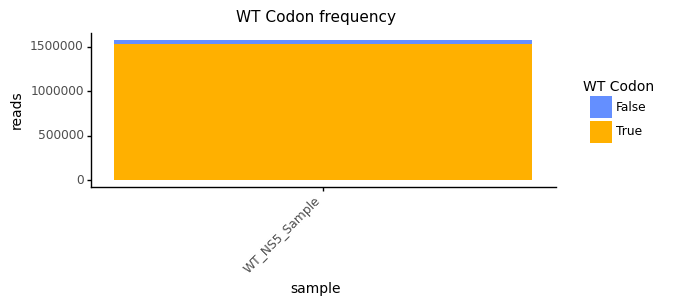

<ggplot: (8757506072077)>

In [96]:
wt_freq = (p9.ggplot(results_annotated) +
              p9.aes(x='sample_name',
                     fill='wt') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('WT Codon frequency') +
              p9.labs(x='sample',
                      y='reads',
                      fill='WT Codon') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(wt_freq)

Codon counts per sample

In [ ]:
codon_counts = (p9.ggplot(results_annotated) +
                p9.aes(x='codon',) +
                p9.geom_bar(stat='count') +
                p9.facet_grid('sample_name~') +
                p9.ggtitle('Codon counts') +
                p9.labs(x='codon',
                        y='reads') +
                p9.theme(figure_size=(10, 8),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(rotation=90),
                         strip_text_y=p9.element_text(angle = 0))
               )

display(codon_counts)